# Goal

* Based on scRecounter cell counts and SRA metadata on dataset release dates, assess the cell counts over time for SRA

In [1]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
from SRAgent.db.connect import db_connect
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [2]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])

In [3]:
# set number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

In [4]:
def pandas_complete(df: pd.DataFrame, 
                    group_cols: list, 
                   fill_cols: dict = None, 
                   fill_value: float = 0) -> pd.DataFrame:
    """
    Equivalent of tidyr::complete - fills missing combinations of grouping variables.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    group_cols : list
        List of column names to create combinations from
    fill_cols : dict, optional
        Dictionary mapping column names to fill values for missing combinations.
        If None, all non-grouping columns will be filled with fill_value
    fill_value : float, default 0
        Default value to fill missing combinations with
        
    Returns:
    --------
    pd.DataFrame
        Complete dataframe with all combinations and filled values
        
    Example:
    --------
    # Fill missing combinations with 0 for 'count' column
    df_complete = pandas_complete(df, 
                                 group_cols=['year', 'category'], 
                                 fill_cols={'count': 0})
    
    # Fill all non-grouping columns with 0
    df_complete = pandas_complete(df, group_cols=['year', 'category'])
    """
    import itertools
    
    # Get unique values for each grouping column
    unique_values = [df[col].unique() for col in group_cols]
    
    # Create all possible combinations
    all_combinations = list(itertools.product(*unique_values))
    df_complete = pd.DataFrame(all_combinations, columns=group_cols)
    
    # Merge with original data
    df_merged = df_complete.merge(df, on=group_cols, how='left')
    
    # Fill missing values
    if fill_cols is None:
        # Fill all non-grouping columns with fill_value
        non_group_cols = [col for col in df_merged.columns if col not in group_cols]
        fill_dict = {col: fill_value for col in non_group_cols}
    else:
        fill_dict = fill_cols
    
    df_result = df_merged.fillna(fill_dict)
    
    return df_result


# Get release dates

In [5]:
# obtaining the release dates using the SRAgent utility script
exe = base_dir.parent / "SRAgent" / "scripts" / "get-srx-release-date.py"
!{exe} --help

usage: get-srx-release-date.py [-h] [--accessions ACCESSIONS [ACCESSIONS ...]]
                               [--use-db] [--output OUTPUT] [--limit LIMIT]
                               [--tenant {test,prod}]
                               [--batch-size BATCH_SIZE] [--retries RETRIES]

Obtain the release dates for SRA experiment accessions

options:
  -h, --help            show this help message and exit
  --accessions ACCESSIONS [ACCESSIONS ...]
                        SRX accessions to use; can be a CSV file with a
                        'srx_accession' column (default: None)
  --use-db              Use the database to get the SRX accessions (default:
                        False)
  --output OUTPUT       Output file name (default: srx_dates.csv)
  --limit LIMIT         Limit the number of records to process (default: None)
  --tenant {test,prod}  Database tenant to use (default: test)
  --batch-size BATCH_SIZE
                        Number of accessions to process per BigQuery bat

In [6]:
# run the script to get the release dates
#release_date_file = base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
#!{exe} --tenant prod --use-db --output {release_date_file}

In [7]:
# run the script to get the release dates
#release_date_file = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates_TMP.csv"
#!{exe} --tenant prod --accessions missing_release_date.csv --output {release_date_file}

In [8]:
# x =  base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
# y =  base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates_TMP.csv"
# z = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates.csv"
# !cat {x} > {z} 
# !tail -n +2 {y} >> {z}

In [9]:
# read in the release dates
release_date_file = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates.csv.gz"
df_release_dates = pd.read_csv(release_date_file)
df_release_dates

,srx_accession,release_date
0,SRX7016897,2019-10-18
1,SRX7016896,2019-10-18
...,...,...
61420,NRX0000218,NaN
61421,NRX0000554,NaN


In [10]:
# number NaN for release_date
df_release_dates["release_date"].isna().sum()

818

# Get scRecounter cell counts 

In [11]:
# set tenant
os.environ["DYNACONF"] = "prod"

In [12]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the star query with feature filter (case insensitive)
    star_query = (
        Query.from_(star_table)
        .select('*')
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )

    #return pd.read_sql_query(str(star_query), conn)
    
    # Build the main query with join
    # Assuming you want all columns from both tables except feature from star and _at columns from meta
    main_query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession'),
            star_table.feature,
            star_table.estimated_number_of_cells,
            star_table.median_reads_per_cell,
            star_table.median_umi_per_cell,
            star_table.median_feature_per_cell,
            star_table.number_of_reads,
            meta_table.lib_prep,
            meta_table.tech_10x,
            meta_table.organism,
            meta_table.tissue,
            meta_table.tissue_ontology_term_id,
            meta_table.cell_prep
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
        .where(
            meta_table.lib_prep == "10x_Genomics"
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(main_query), conn)

with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,429254174,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,197317627,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61379,NRX0000701,GeneFull_Ex50pAS,9774,40290.0,21058.0,5970.0,739166302,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus
61380,NRX0000702,GeneFull_Ex50pAS,9783,43265.0,17860.0,5505.0,655794822,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus


# Join

In [13]:
# merge the two dataframes
df_cells = df_cells.merge(df_release_dates, on="srx_accession", how="left")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,429254174,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,197317627,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000701,GeneFull_Ex50pAS,9774,40290.0,21058.0,5970.0,739166302,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaN
61421,NRX0000702,GeneFull_Ex50pAS,9783,43265.0,17860.0,5505.0,655794822,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaN


In [14]:
# missing release_date
df_cells["release_date"].isna().sum()

818

In [15]:
# format
## convert release_date to datetime
df_cells["release_date"] = pd.to_datetime(df_cells["release_date"])
## bin release date by month
df_cells["release_date_month"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('M')
## bin release date by year
df_cells["release_date_year"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('Y')
## change certain tech_10x labels to "other"
keep_tech_10x = ["3_prime_gex", "5_prime_gex", "multiome", "vdj", "feature_barcoding", "cellplex"]
df_cells["tech_10x"] = df_cells["tech_10x"].apply(lambda x: "other" if x not in keep_tech_10x else x)

# show 
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,429254174,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29,2023-06,2023
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,197317627,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26,2023-09,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000701,GeneFull_Ex50pAS,9774,40290.0,21058.0,5970.0,739166302,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT
61421,NRX0000702,GeneFull_Ex50pAS,9783,43265.0,17860.0,5505.0,655794822,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT


In [16]:
# total cells
x = df_cells["estimated_number_of_cells"].sum()
print(f"Total cells: {x}")

Total cells: 502764327


In [17]:
# total reads in trillions
x = df_cells["number_of_reads"].sum() / 1e12
print(f"Total reads in trillions: {x:.1f}")

Total reads in trillions: 13.8


# Summarize

## Culm cell count by year

### By tech_10x

In [59]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,estimated_number_of_cells
0,2018,other,1853
1,2019,3_prime_gex,353318
...,...,...,...
43,2025,other,3249787
44,2025,vdj,146838


In [60]:
# Check: sum the number of cells
df_cells_sum["estimated_number_of_cells"].sum()

497726918

In [61]:
# sum by tech_10x
pd.set_option('display.max_rows', 10)
df_cells_sum_tech = df_cells.groupby(["tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values(by="estimated_number_of_cells", ascending=False)
df_cells_sum_tech

,tech_10x,estimated_number_of_cells
0,3_prime_gex,387170007
1,5_prime_gex,69159929
5,other,20934193
4,multiome,11933028
3,feature_barcoding,9847542
6,vdj,3250170
2,cellplex,469458


In [62]:
# fraction that is 3_prime_gex
prime3 = df_cells_sum_tech[df_cells_sum_tech["tech_10x"] == "3_prime_gex"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_tech["estimated_number_of_cells"].sum()
print(f"fraction 3_prime_gex: ({prime3 / total:.2%})")

fraction 3_prime_gex: (77.01%)


In [63]:
# amount of 5' for the past 2 years
target_years =[pd.Period('2024', freq='Y-DEC'), pd.Period('2025', freq='Y-DEC')]
df_cells_sum_tech = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
prime5 = df_cells_sum_tech[df_cells_sum_tech["tech_10x"] == "5_prime_gex"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_tech["estimated_number_of_cells"].sum()
print(f"fraction 5_prime_gex for 2024-2025: ({prime5 / total:.2%})")

fraction 5_prime_gex for 2024-2025: (17.42%)


In [64]:
# expand the table
pd.set_option('display.max_rows', 4)
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "tech_10x"]
)
df_cells_sum

,release_date_year,tech_10x,estimated_number_of_cells
0,2018,other,1853.0
1,2018,3_prime_gex,0.0
...,...,...,...
54,2025,vdj,146838.0
55,2025,cellplex,30986.0


In [65]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['tech_10x', 'release_date_year'])  # Ensure proper ordering
    .groupby('tech_10x')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'tech_10x']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x
1,0.0,2018,3_prime_gex
8,353318.0,2019,3_prime_gex
...,...,...,...
47,3103332.0,2024,vdj
54,3250170.0,2025,vdj


In [66]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x
1,0.0,2018,3_prime_gex
8,353318.0,2019,3_prime_gex
...,...,...,...
6,441864351.0,2024,Total
7,497726918.0,2025,Total


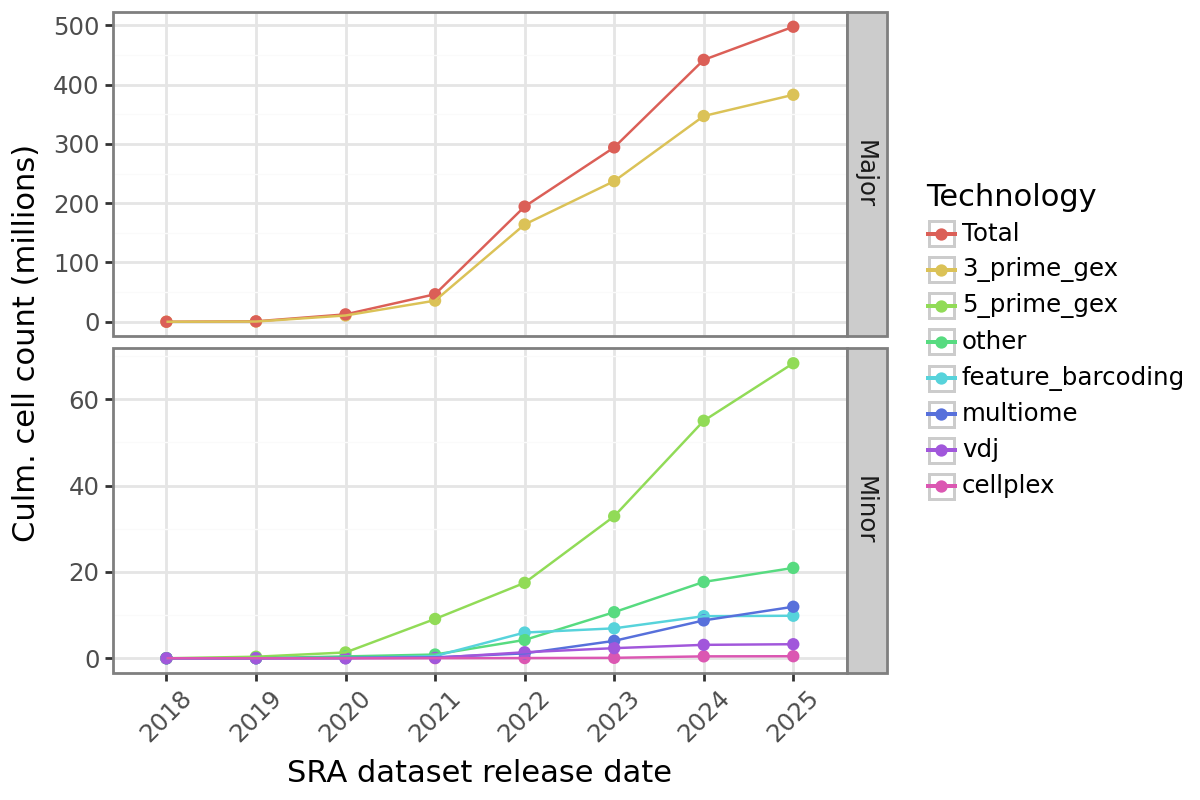

In [67]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

# copy for editing
df = df_cells_sum.copy()

# order by tech_10x
df_cnt_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False)
tech_10x_order = df_cnt_sum["tech_10x"].unique().tolist()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=tech_10x_order)

df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ .", scales="free_y") +
    # pn.scale_color_manual(
    #     values=color_dict,
    # ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

In [68]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


### By tech_10x and lib_prep

In [69]:
group_cols = ["release_date_year", "tech_10x", "cell_prep"]

In [70]:
# summarize cells by groups
df_cells_sum = df_cells.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,cell_prep,estimated_number_of_cells
0,2018,other,single_nucleus,1853
1,2019,3_prime_gex,single_cell,353318
...,...,...,...,...
82,2025,other,single_nucleus,198368
83,2025,vdj,single_cell,146838


In [71]:
# complete the table
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "tech_10x", "cell_prep"]
)
df_cells_sum

,release_date_year,tech_10x,cell_prep,estimated_number_of_cells
0,2018,other,single_nucleus,1853.0
1,2018,other,single_cell,0.0
...,...,...,...,...
222,2025,cellplex,unsure,0.0
223,2025,cellplex,not_applicable,0.0


In [72]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
7,0.0,2018,3_prime_gex,not_applicable
5,0.0,2018,3_prime_gex,single_cell
...,...,...,...,...
216,0.0,2025,vdj,single_nucleus
218,0.0,2025,vdj,unsure


In [73]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year", "cell_prep"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
7,0.0,2018,3_prime_gex,not_applicable
5,0.0,2018,3_prime_gex,single_cell
...,...,...,...,...
30,37187529.0,2025,Total,single_nucleus
31,1015882.0,2025,Total,unsure


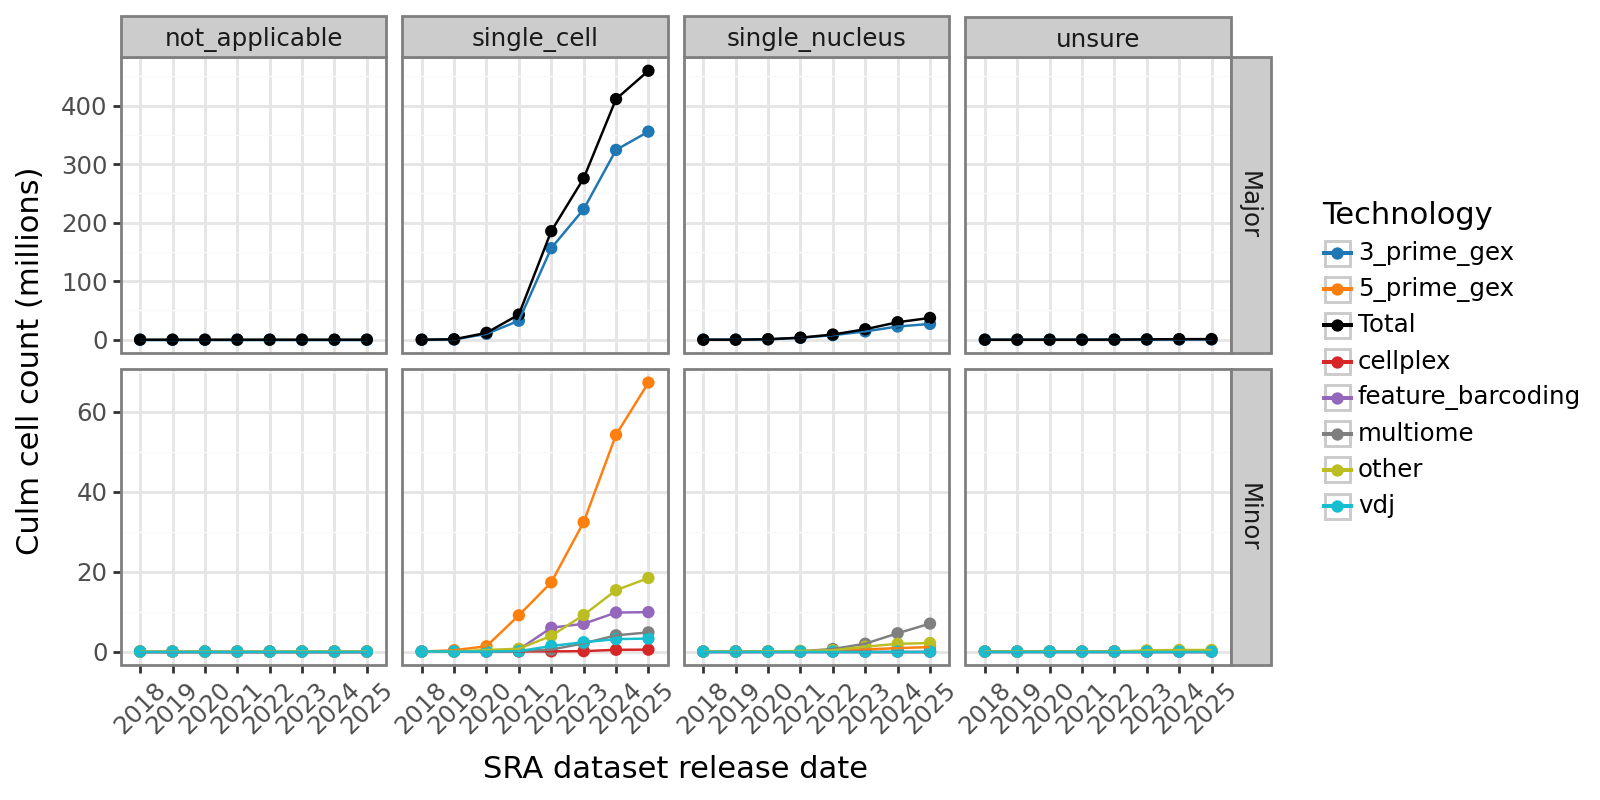

In [74]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

df = df_cells_sum.copy()
df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ cell_prep", scales="free_y") +
    pn.scale_color_manual(
        values=color_dict,
    ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

### By organism

In [75]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,organism,estimated_number_of_cells
0,2018,Mus musculus,1853
1,2019,Homo sapiens,590436
...,...,...,...
107,2025,Solanum lycopersicum,10877
108,2025,Sus scrofa,439317


In [76]:
# sum by organism across all years
df_cells_sum_organism = df_cells_sum.groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum_organism

,organism,estimated_number_of_cells
0,Arabidopsis thaliana,1984986
1,Bos taurus,1194485
...,...,...
25,Taeniopygia guttata,5789
26,Zea mays,279544


In [78]:
# % human
human = df_cells_sum_organism[df_cells_sum_organism["organism"] == "Homo sapiens"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_organism["estimated_number_of_cells"].sum()
print(f"fraction human: ({human / total:.2%})")

fraction human: (60.37%)


In [79]:
# % mouse
mouse = df_cells_sum_organism[df_cells_sum_organism["organism"] == "Mus musculus"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_organism["estimated_number_of_cells"].sum()
print(f"fraction mouse: ({mouse / total:.2%})")

fraction mouse: (32.87%)


In [ ]:
# calculate the % increase for each organism from 2022 to 2025
## 2022
target_years =[pd.Period('2022', freq='Y-DEC')]
df_cells_sum_organism_2022 = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
#df_cells_sum_organism_2022["release_date_year"] = "2022"
df_cells_sum_organism_2022["estimated_number_of_cells"] = df_cells_sum_organism_2022["estimated_number_of_cells"] / df_cells_sum_organism_2022["estimated_number_of_cells"].sum() * 100

## 2025
target_years =[pd.Period('2025', freq='Y-DEC')]
df_cells_sum_organism_2025 = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
#df_cells_sum_organism_2025["release_date_year"] = "2025"
df_cells_sum_organism_2025["estimated_number_of_cells"] = df_cells_sum_organism_2025["estimated_number_of_cells"] / df_cells_sum_organism_2025["estimated_number_of_cells"].sum() * 100

## merge
df_cells_sum_organism_2022_2025 = pd.merge(df_cells_sum_organism_2022, df_cells_sum_organism_2025, on="organism", how="inner", suffixes=("_2022", "_2025"))
df_cells_sum_organism_2022_2025["delta_perc_cells"] = df_cells_sum_organism_2022_2025["estimated_number_of_cells_2025"] - df_cells_sum_organism_2022_2025["estimated_number_of_cells_2022"]
pd.set_option('display.max_rows', 30)
df_cells_sum_organism_2022_2025.sort_values(by="delta_perc_cells", ascending=False)


,organism,estimated_number_of_cells_2022,estimated_number_of_cells_2025,delta_perc_cells
9,Mus musculus,16.819798,41.169438,24.349640
8,Macaca mulatta,1.113180,2.081286,0.968106
11,Ovis aries,0.090320,0.950551,0.860231
14,Sus scrofa,0.146526,0.786425,0.639898
13,Rattus norvegicus,0.161350,0.781543,0.620193
4,Danio rerio,0.714024,1.143571,0.429547
3,Callithrix jacchus,0.366840,0.673347,0.306507
1,Bos taurus,0.170427,0.396298,0.225871
6,Gallus gallus,0.136166,0.294736,0.158570
5,Drosophila melanogaster,0.537700,0.652340,0.114641


In [31]:
# complete the table
pd.set_option('display.max_rows', 4)
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "organism"]
)
df_cells_sum

,release_date_year,organism,estimated_number_of_cells
0,2018,Mus musculus,1853.0
1,2018,Homo sapiens,0.0
...,...,...,...
214,2025,Gasterosteus aculeatus,79256.0
215,2025,Monodelphis domestica,33337.0


In [32]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['organism', 'release_date_year'])  # Ensure proper ordering
    .groupby('organism')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'organism']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,organism
13,0.0,2018,Arabidopsis thaliana
40,0.0,2019,Arabidopsis thaliana
...,...,...,...
174,279544.0,2024,Zea mays
201,279544.0,2025,Zea mays


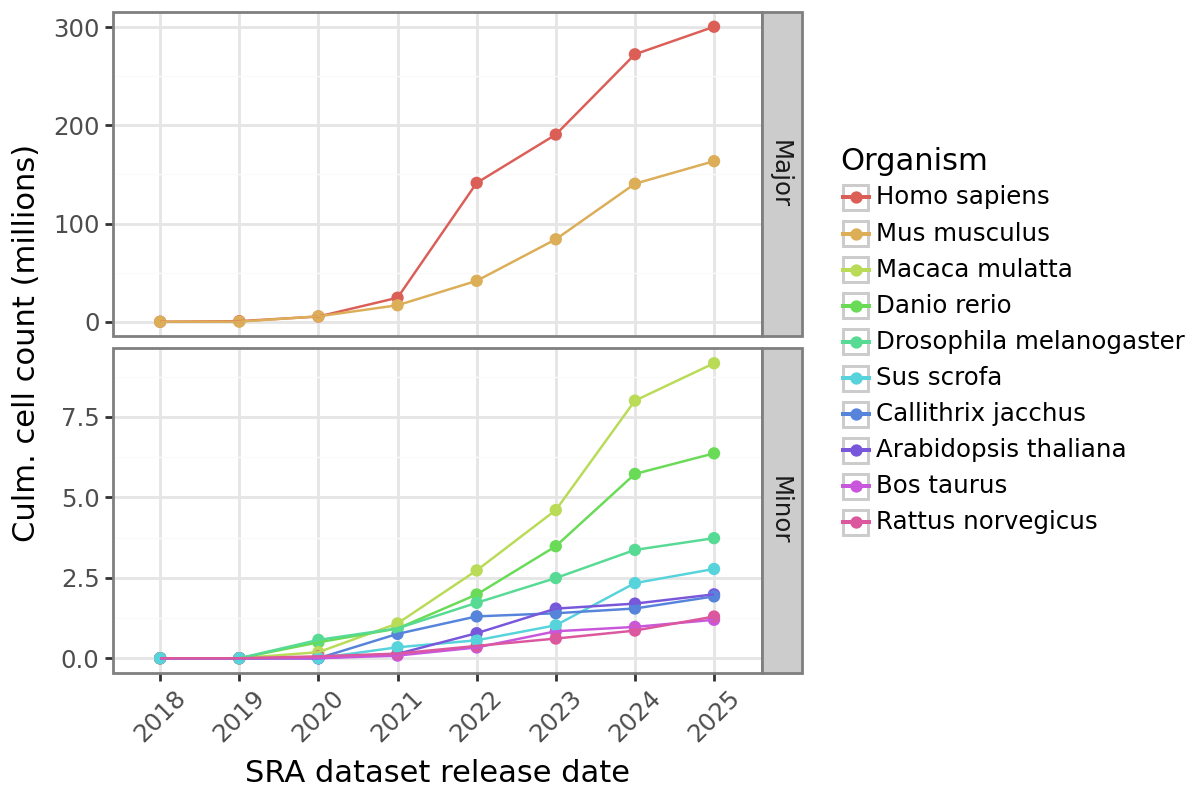

In [33]:
df = df_cells_sum.copy()

# filter to top10 organisms by total cell count
df_top10 = df.groupby("organism").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False).head(10)
df = df[df["organism"].isin(df_top10["organism"])]

# order by organism
organism_order = df_top10["organism"].tolist()
df["organism"] = pd.Categorical(df["organism"], categories=organism_order)

# add facet
df["facet"] = df["organism"].apply(lambda x: "Major" if x in ["Homo sapiens", "Mus musculus"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="organism")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="organism")) +
    pn.facet_grid("facet ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  
    )
)
p

In [34]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_organism.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


### By tissue

In [35]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [36]:
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX24274840,GeneFull_Ex50pAS,13950,3.0,2.0,2.0,5061432,10x_Genomics,3_prime_gex,Homo sapiens,unsure,,single_cell,2024-05-06,2024-05,2024,other
1,SRX24131493,GeneFull_Ex50pAS,18667,665.0,67.0,45.0,42465315,10x_Genomics,vdj,Homo sapiens,blood,UBERON:0000178,single_cell,2024-05-13,2024-05,2024,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000701,GeneFull_Ex50pAS,9774,40290.0,21058.0,5970.0,739166302,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain
61421,NRX0000702,GeneFull_Ex50pAS,9783,43265.0,17860.0,5505.0,655794822,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain


In [37]:
group_cols = ["release_date_year", "tissue_category"]

In [38]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,estimated_number_of_cells
0,2018,kidney,1853
1,2019,adipose tissue,4971
...,...,...,...
385,2025,vasculature,801080
386,2025,yolk sac,93321


In [39]:
# compete the table
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,estimated_number_of_cells
0,2018,kidney,1853.0
1,2018,adipose tissue,0.0
...,...,...,...
582,2025,seed,0.0
583,2025,seedling,0.0


In [40]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category
13,0.0,2018,abdomen
1,0.0,2018,adipose tissue
...,...,...,...
562,6477248.0,2025,vasculature
578,182268.0,2025,yolk sac


In [41]:
# # add total number of cells to the table
# df = df_cells_tissues_sum.groupby(["release_date_year"]).sum().reset_index()
# df["tech_10x"] = "Total"
# df_cells_tissues_sum = pd.concat([df_cells_tissues_sum, df])
# df_cells_tissues_sum

/tmp/ipykernel_1510727/2690258807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1510727/2690258807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


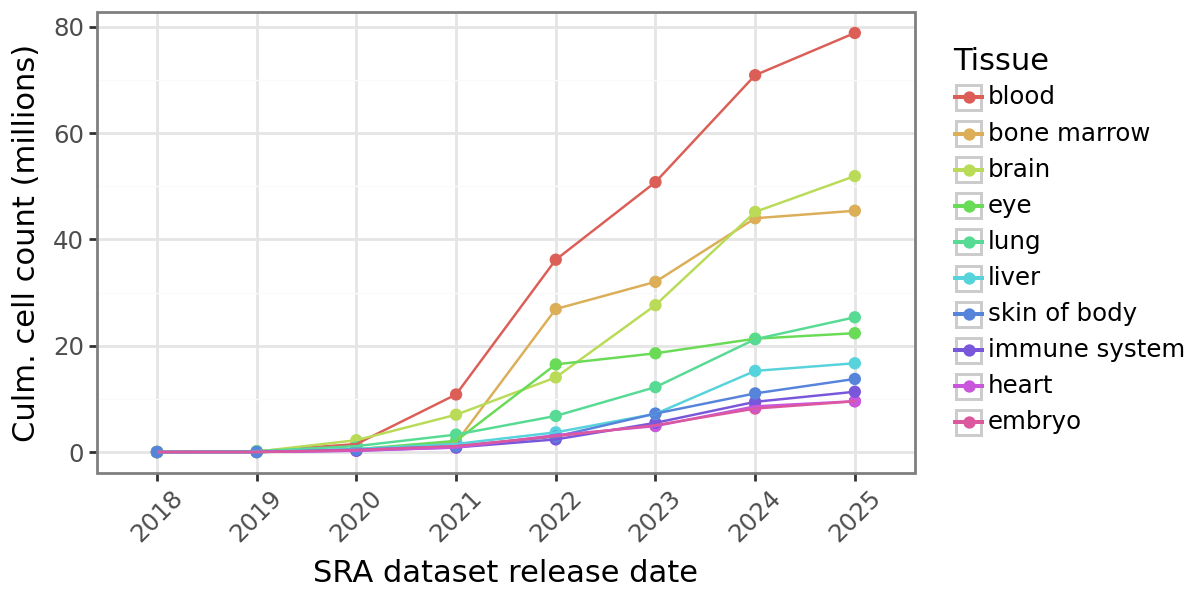

In [42]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [43]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


### tissues for human and mouse

In [44]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [ ]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1096,2025,yolk sac,Macaca mulatta,67206
1097,2025,yolk sac,Mus musculus,26115


In [46]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1094,2025,vasculature,Mus musculus,330365
1097,2025,yolk sac,Mus musculus,26115


In [47]:
# compete
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category", "organism"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853.0
1,2018,kidney,Homo sapiens,0.0
...,...,...,...,...
1086,2025,flower,Mus musculus,0.0
1087,2025,flower,Homo sapiens,0.0


In [48]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
95,0.0,2018,abdomen,Homo sapiens
94,0.0,2018,abdomen,Mus musculus
...,...,...,...,...
1079,24227.0,2025,yolk sac,Homo sapiens
1078,90835.0,2025,yolk sac,Mus musculus


/tmp/ipykernel_1510727/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1510727/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


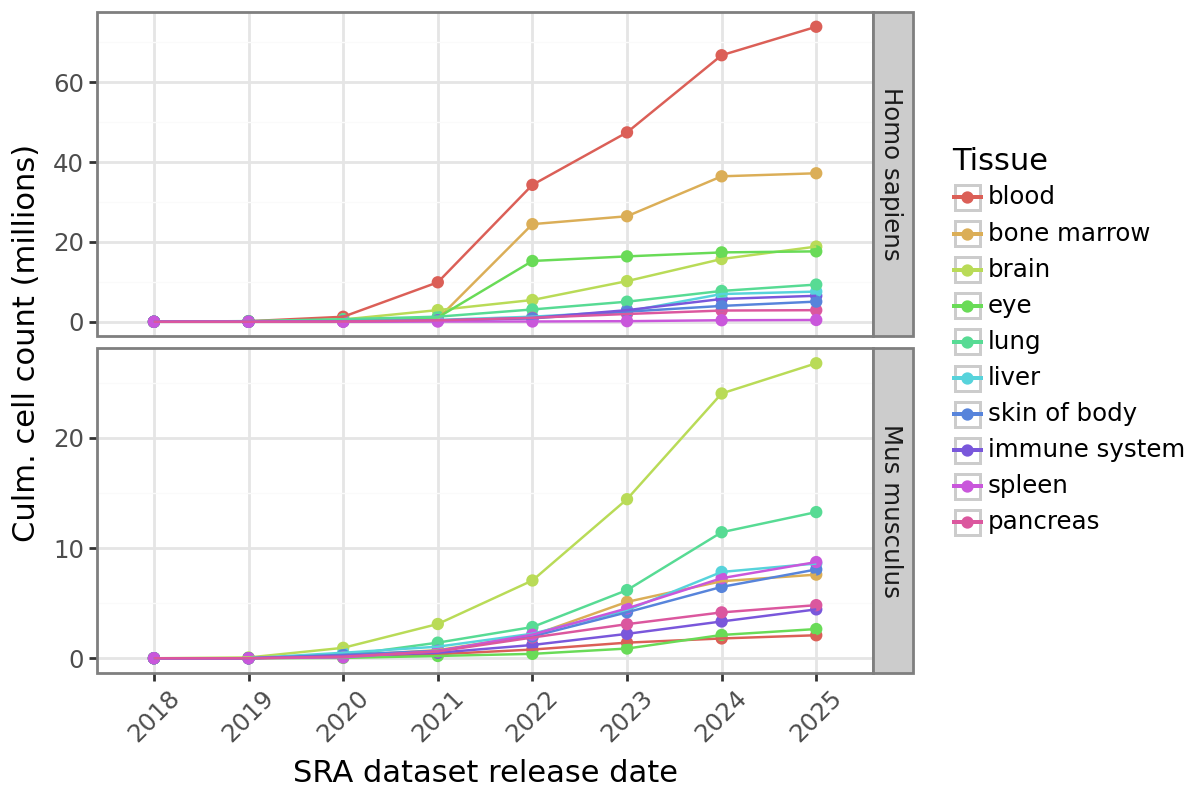

In [49]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [50]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [51]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


## By tissue and tech_10x

In [52]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [53]:
# merge with tissue categories
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX24274840,GeneFull_Ex50pAS,13950,3.0,2.0,2.0,5061432,10x_Genomics,3_prime_gex,Homo sapiens,unsure,,single_cell,2024-05-06,2024-05,2024,other
1,SRX24131493,GeneFull_Ex50pAS,18667,665.0,67.0,45.0,42465315,10x_Genomics,vdj,Homo sapiens,blood,UBERON:0000178,single_cell,2024-05-13,2024-05,2024,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000701,GeneFull_Ex50pAS,9774,40290.0,21058.0,5970.0,739166302,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain
61421,NRX0000702,GeneFull_Ex50pAS,9783,43265.0,17860.0,5505.0,655794822,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain


In [54]:
# select groups
group_cols = ["release_date_year", "tissue_category", "tech_10x"]

In [55]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2018,kidney,other,1853
1,2019,adipose tissue,3_prime_gex,4971
...,...,...,...,...
1009,2025,vasculature,other,40890
1010,2025,yolk sac,3_prime_gex,93321


In [56]:
# add zeros via pandas_complete
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=group_cols, 
    fill_cols={"estimated_number_of_cells": 0}
)
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2018,kidney,other,1853.0
1,2018,kidney,3_prime_gex,0.0
...,...,...,...,...
4086,2025,seedling,vdj,0.0
4087,2025,seedling,cellplex,0.0


In [57]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,tech_10x
92,0.0,2018,abdomen,3_prime_gex
93,0.0,2018,abdomen,5_prime_gex
...,...,...,...,...
4046,0.0,2025,yolk sac,other
4051,0.0,2025,yolk sac,vdj


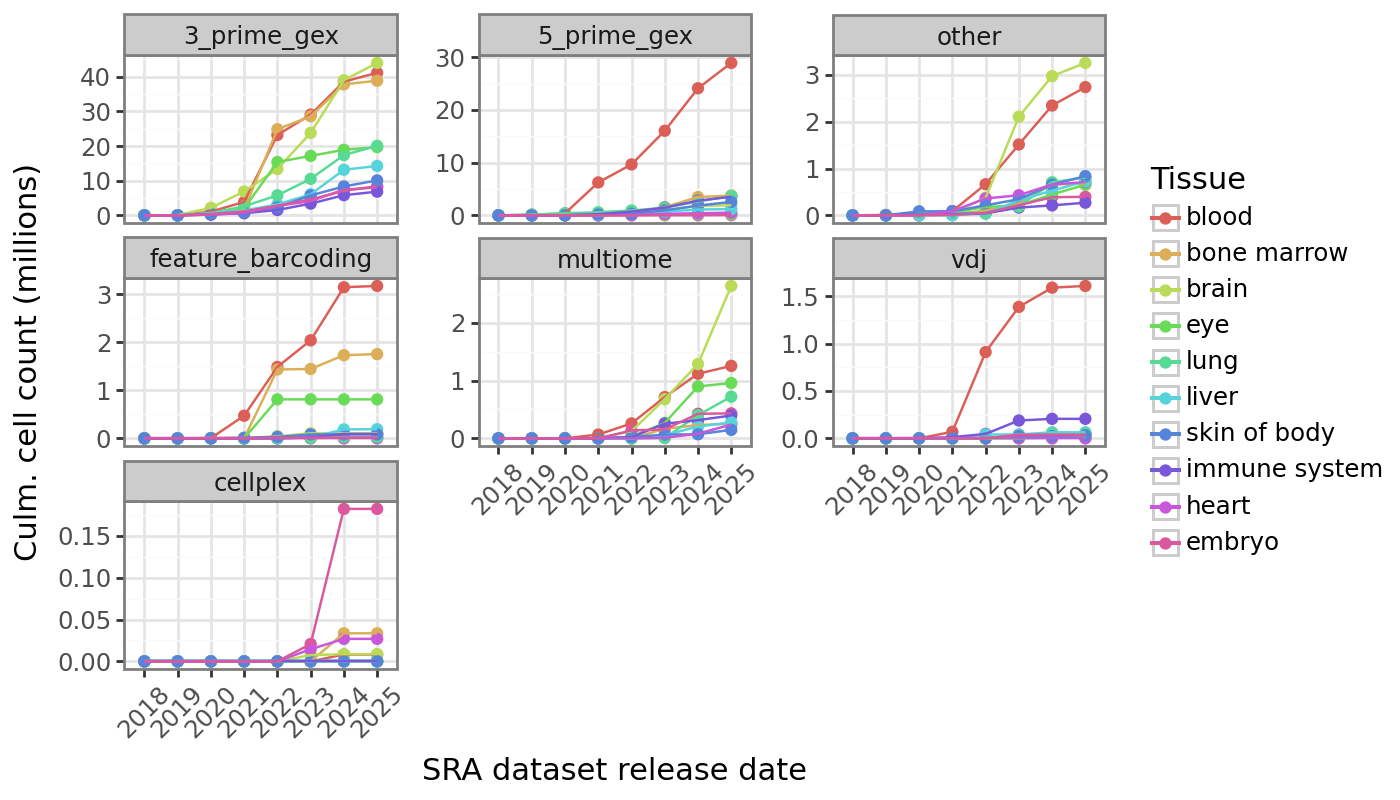

In [58]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "tech_10x", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# filter to top N tech_10x
# df_cells_tissues_sum_top10_tech = (
#     df_cells_tissues_sum[["tech_10x", "estimated_number_of_cells"]]
#     .groupby("tech_10x").sum()
#     .sort_values("estimated_number_of_cells", ascending=False)
#     .head(7)
#     .reset_index()
# )
# df = df[df["tech_10x"].isin(df_cells_tissues_sum_top10_tech["tech_10x"])]

# filter out fixed_rna
df = df[df["tech_10x"] != "fixed_rna"]

# order by sum of tech_10x by setting tech_10x as Categorical 
df_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).sort_values("estimated_number_of_cells", ascending=False).reset_index()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=df_sum["tech_10x"].tolist())

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6


# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [59]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


#### Just top 6

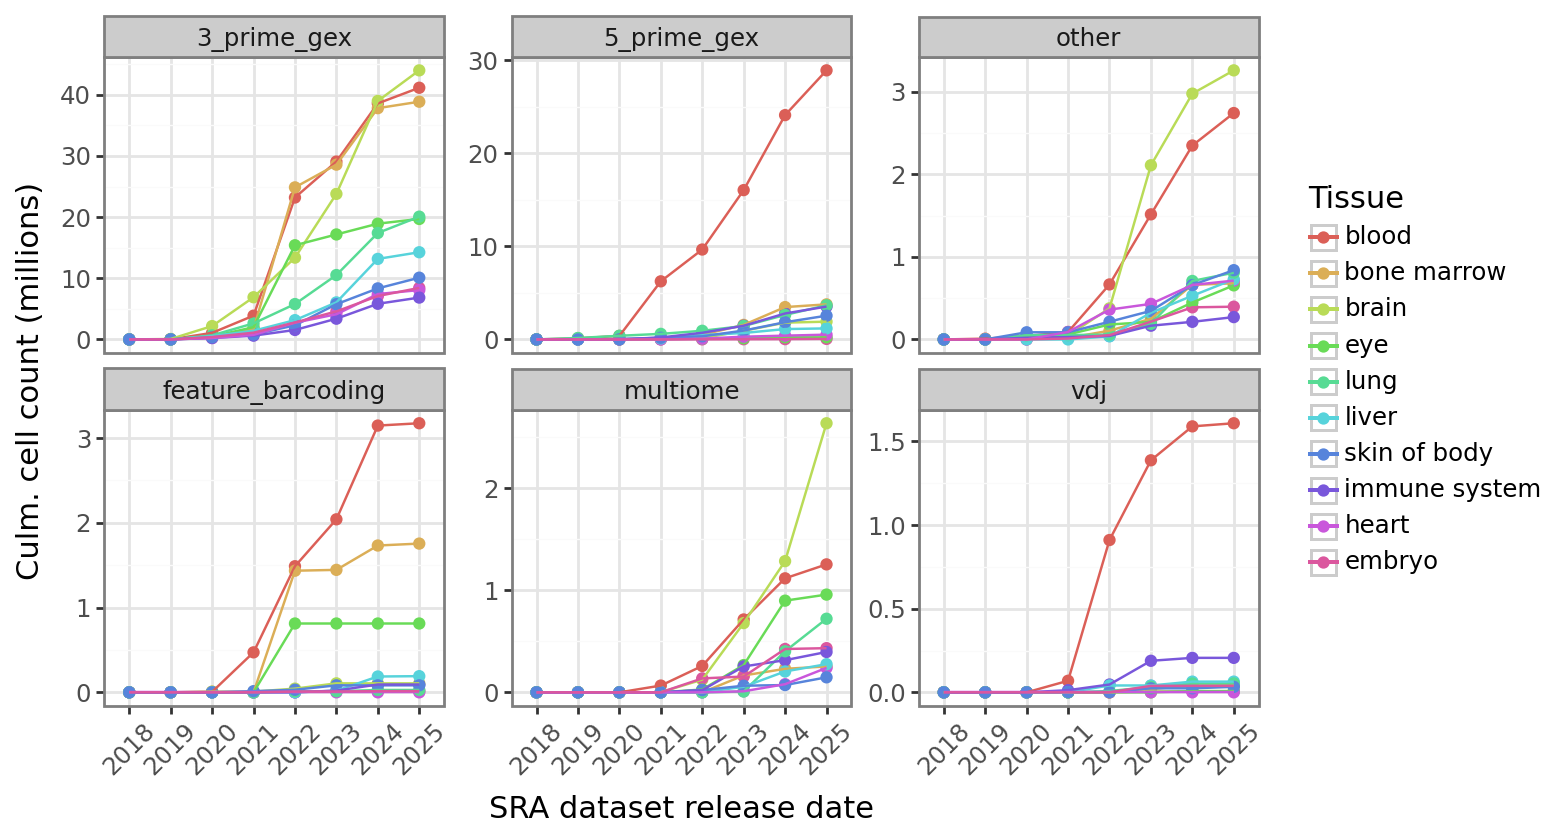

In [60]:
x = ["3_prime_gex", "5_prime_gex", "other", "feature_barcoding", "multiome", "vdj"]

# plot the number of cells over time
p = (
    pn.ggplot(
        df[df["tech_10x"].isin(x)], 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [61]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech_top6.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


### tissues for human and mouse

In [62]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [63]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1096,2025,yolk sac,Macaca mulatta,67206
1097,2025,yolk sac,Mus musculus,26115


In [64]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1094,2025,vasculature,Mus musculus,330365
1097,2025,yolk sac,Mus musculus,26115


In [65]:
# get complete table
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category", "organism"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853.0
1,2018,kidney,Homo sapiens,0.0
...,...,...,...,...
1086,2025,flower,Mus musculus,0.0
1087,2025,flower,Homo sapiens,0.0


In [66]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
95,0.0,2018,abdomen,Homo sapiens
94,0.0,2018,abdomen,Mus musculus
...,...,...,...,...
1079,24227.0,2025,yolk sac,Homo sapiens
1078,90835.0,2025,yolk sac,Mus musculus


/tmp/ipykernel_1510727/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1510727/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


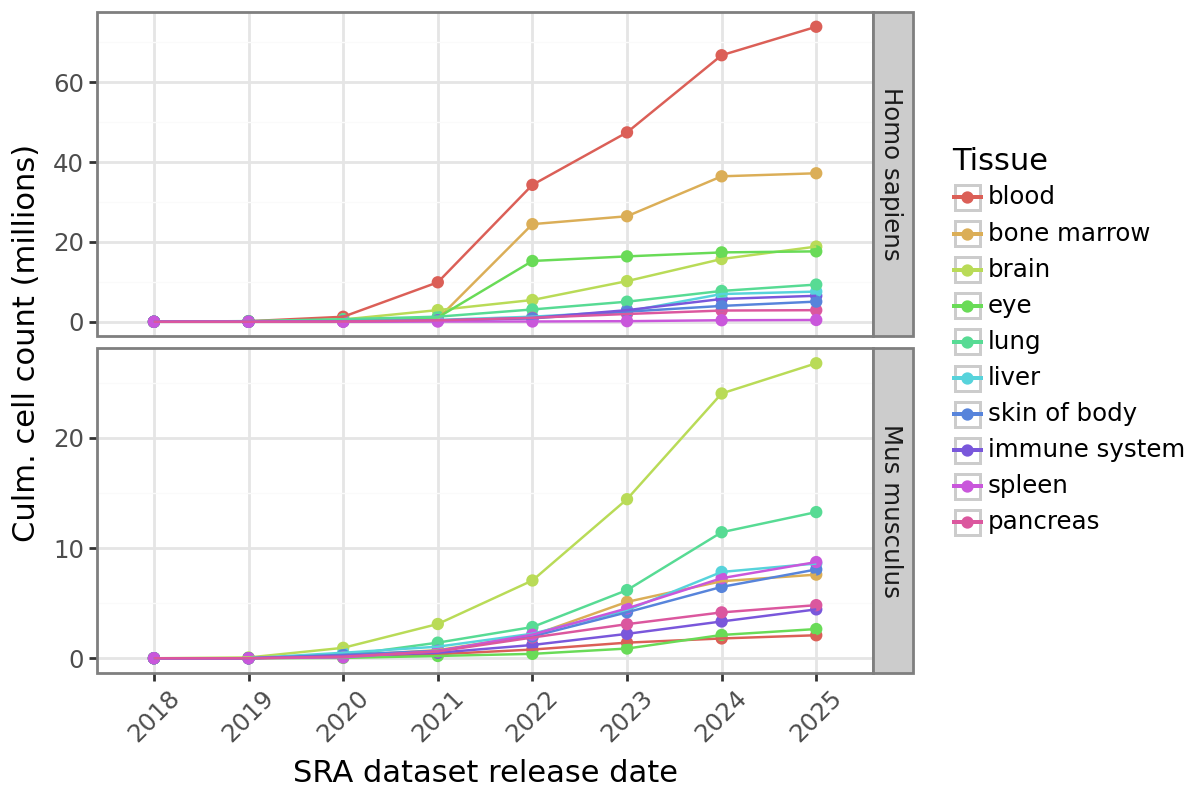

In [67]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [68]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [69]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


## By disease for human and mouse

In [18]:
pd.set_option('display.max_rows', 4)
infile = '/large_storage/ctc/public/scBasecamp/SRA_Agent_metadata.parquet'
df_disease = pd.read_parquet(infile)[["srx_accession", "disease group", "disease_tag"]].rename({"disease group": "disease_group"}, axis=1)
df_disease

,srx_accession,disease_group,disease_tag
0,SRX5444597,Healthy,unclassified
1,SRX5822385,Healthy,none
...,...,...,...
134940,SRX29323945,Cancer,cancer
134942,SRX29351873,Healthy,none


In [19]:
# merge disease data
df_cells_disease = df_cells.merge(df_disease, on="srx_accession", how="inner")
# filter to mouse/humna
df_cells_disease = df_cells_disease[df_cells_disease["organism"].isin(["Mus musculus", "Homo sapiens"])]
# status
df_cells_disease

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,disease_group,disease_tag
0,SRX20732890,GeneFull_Ex50pAS,11833,15253.0,8551.0,3025.0,429254174,10x_Genomics,3_prime_gex,Homo sapiens,breast,UBERON:0000310,single_cell,2023-06-29,2023-06,2023,Cancer,cancer
1,ERX10398458,GeneFull_Ex50pAS,7471,9093.0,4582.0,2276.0,197317627,10x_Genomics,3_prime_gex,Homo sapiens,Retina,UBERON:0000966,single_cell,2023-09-26,2023-09,2023,Healthy,unclassified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60727,SRX28816645,GeneFull_Ex50pAS,10839,41022.0,5957.0,2261.0,875910421,10x_Genomics,3_prime_gex,Mus musculus,lung,UBERON:0002048,single_cell,2025-06-25,2025-06,2025,Healthy,none
60728,SRX28816645,GeneFull_Ex50pAS,10839,41022.0,5957.0,2261.0,875910421,10x_Genomics,3_prime_gex,Mus musculus,lung,UBERON:0002048,single_cell,2025-06-25,2025-06,2025,Healthy,none


In [20]:
# grouping columns
group_cols = ["release_date_year", "disease_group"]

In [21]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468
1,2019,Diabetes/Kidney disease,2283
...,...,...,...
62,2025,Ovarian/Uteral cancer,402184
63,2025,Viral infection,2141707


In [22]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468.0
1,2019,Diabetes/Kidney disease,2283.0
...,...,...,...
68,2025,Nervous System disorder,3915396.0
69,2025,Ovarian/Uteral cancer,402184.0


In [23]:
# calculate cumsum
df = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_disease_sum = df.merge(
    df_cells_disease_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_disease_sum 

,estimated_number_of_cells,release_date_year,disease_group
4,0.0,2019,Ageing disease
5,0.0,2019,Blood cancer
...,...,...,...
69,3777807.0,2025,Ovarian/Uteral cancer
63,29460126.0,2025,Viral infection


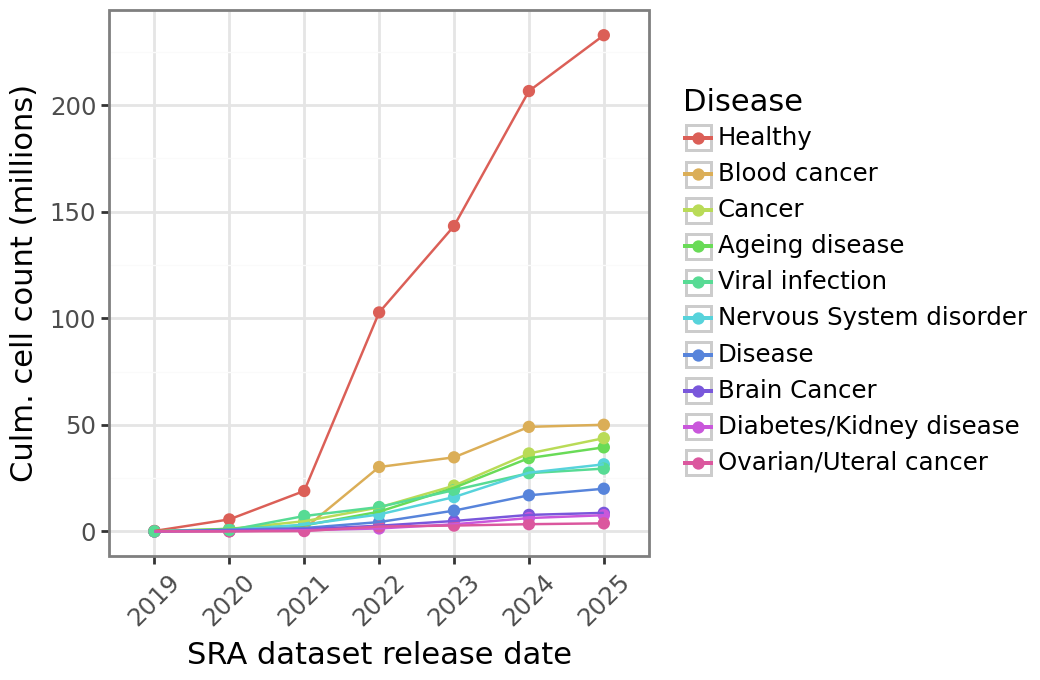

In [24]:
# filter to top 10 tissues
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    #pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(5.2, 3.4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [25]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.2 x 3.4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm.svg


In [26]:
# append row for total cell count
df_total = []
for release_date_year in df_cells_disease_sum["release_date_year"].unique():
    total_cells = df_cells_disease_sum[df_cells_disease_sum["release_date_year"] == release_date_year]["estimated_number_of_cells"].sum() / 1e6
    df_total.append({"release_date_year": release_date_year, "disease_group": "Total", "estimated_number_of_cells": total_cells})

df_total = pd.DataFrame(df_total)
df_j = pd.concat([df, df_total])
df_j

,estimated_number_of_cells,release_date_year,disease_group
4,0.000000,2019,Ageing disease
5,0.000000,2019,Blood cancer
...,...,...,...
5,415.794240,2024,Total
6,467.004755,2025,Total


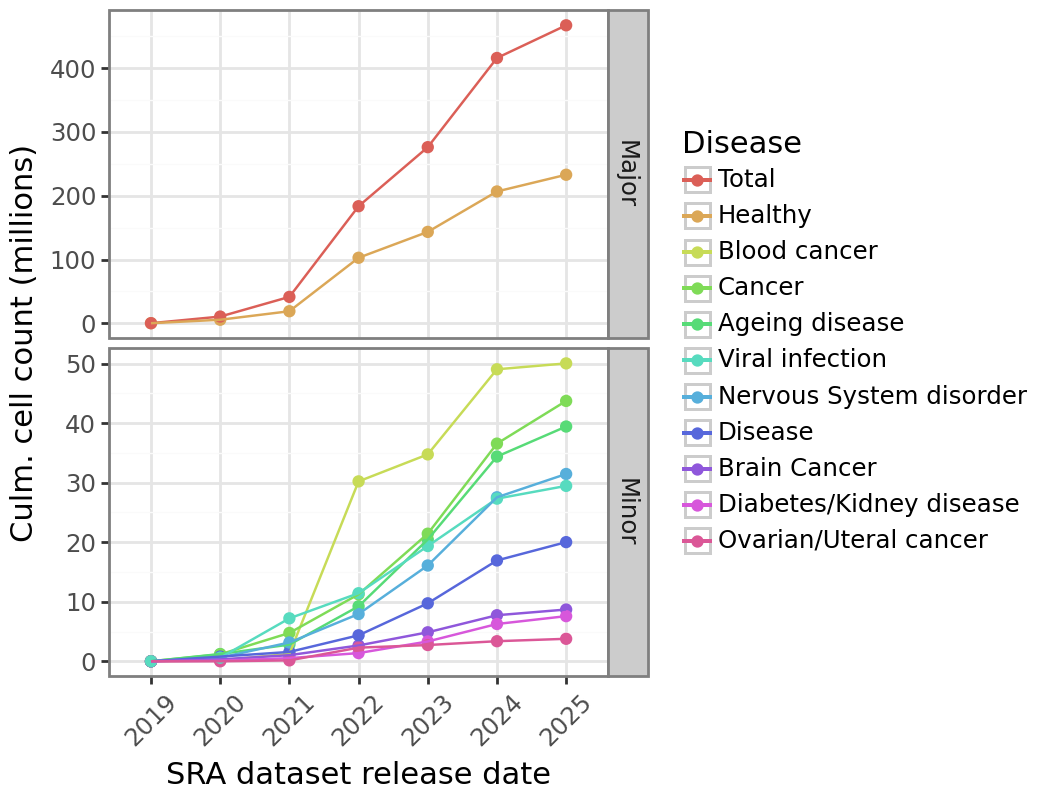

In [27]:
# a grouping columns: "Healthy" vs other
df_j["group"] = df_j["disease_group"].apply(lambda x: "Major" if x in ["Healthy", "Total"] else "Minor")

# move "Total" to the of start the category for Disease
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
disease_order.insert(0, "Total")
df_j["disease_group"] = pd.Categorical(df_j["disease_group"], categories=disease_order, ordered=True)

# plot the number of cells over time
p = (
    pn.ggplot(
        df_j, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.scale_color_discrete() + 
    pn.facet_grid("group ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(5.2, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11, 
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [28]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_total.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.2 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_total.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_total.svg


### Disease rates

In [40]:
group_cols = ["release_date_year", "disease_group"]

In [41]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468
1,2019,Diabetes/Kidney disease,2283
...,...,...,...
62,2025,Ovarian/Uteral cancer,402184
63,2025,Viral infection,2141707


In [42]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468.0
1,2019,Diabetes/Kidney disease,2283.0
...,...,...,...
68,2025,Nervous System disorder,3915396.0
69,2025,Ovarian/Uteral cancer,402184.0


In [43]:
# total sum scaling per year
df_total = df_cells_disease_sum.groupby("release_date_year").agg({"estimated_number_of_cells": "sum"}).reset_index().rename(columns={"estimated_number_of_cells" : "total_cell_count"})
df_cells_disease_sum = df_cells_disease_sum.merge(df_total, on="release_date_year", how="inner")
df_cells_disease_sum["estimated_number_of_cells"] = df_cells_disease_sum["estimated_number_of_cells"] / df_cells_disease_sum["total_cell_count"]
df_cells_disease_sum["estimated_number_of_cells"].describe()

count    70.000000
mean      0.100000
           ...    
75%       0.099382
max       0.898821
Name: estimated_number_of_cells, Length: 8, dtype: float64

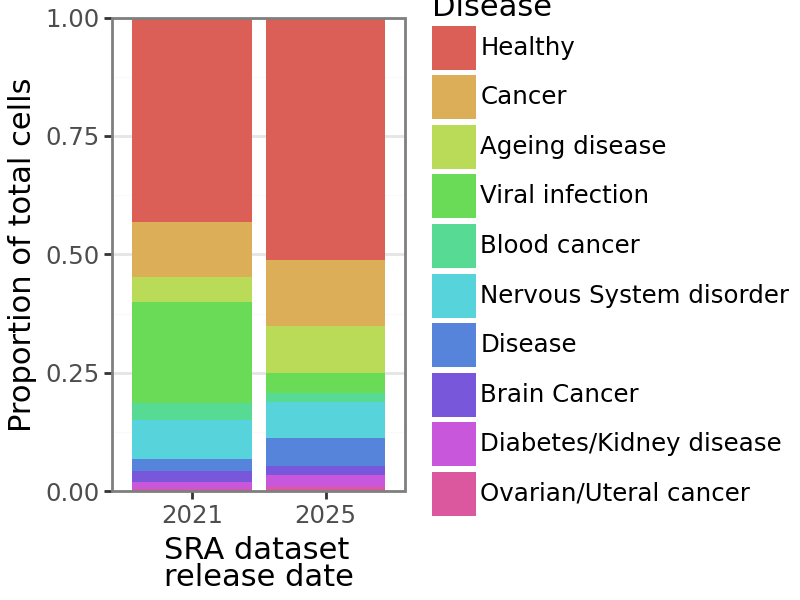

In [46]:
# plot the proportion of cells for 2021 and 2025
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# filter to 2021 and 2025
x = pd.PeriodIndex(['2021', '2025'], freq='Y-DEC')
df_2022 = df[df["release_date_year"].isin(x)]

# plot the proportion of cells for 2021 and 2025
p = (
    pn.ggplot(df_2022, pn.aes(x="release_date_year", y="estimated_number_of_cells", fill="disease_group")) +
    pn.geom_col() +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.labs(
        x = "SRA dataset\nrelease date",
        y = "Proportion of total cells",
        fill = "Disease",
    ) +
    pn.theme(
        figure_size=(4, 3),
        #legend_position="none",
    )
)
p

In [47]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_2021-2025.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_2021-2025.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_2021-2025.svg


In [48]:
# calculate pct_change
df_cells_disease_sum['pct_change'] = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .pct_change() * 100
)
x = pd.PeriodIndex(['2022', '2023', '2024', '2025'], freq='Y-DEC')
df_cells_disease_sum = df_cells_disease_sum[df_cells_disease_sum["release_date_year"].isin(x)]
df_cells_disease_sum["pct_change"].describe()

count     40.000000
mean      36.552678
            ...    
75%       79.804533
max      469.693500
Name: pct_change, Length: 8, dtype: float64

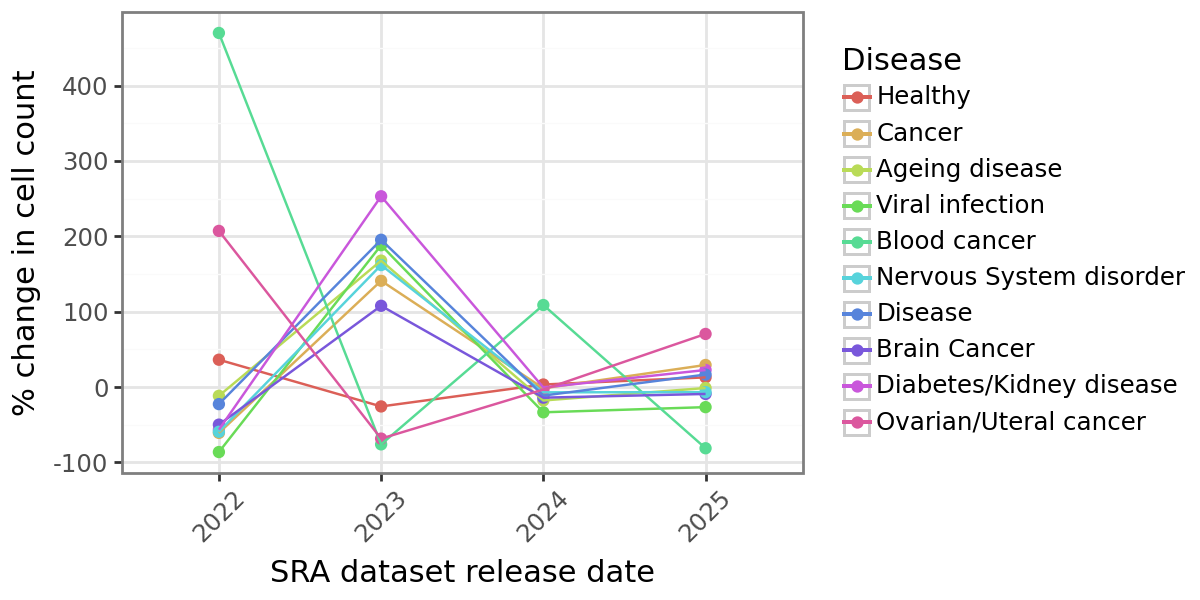

In [49]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="pct_change", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.labs(
        x = "SRA dataset release date",
        y = "% change in cell count",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

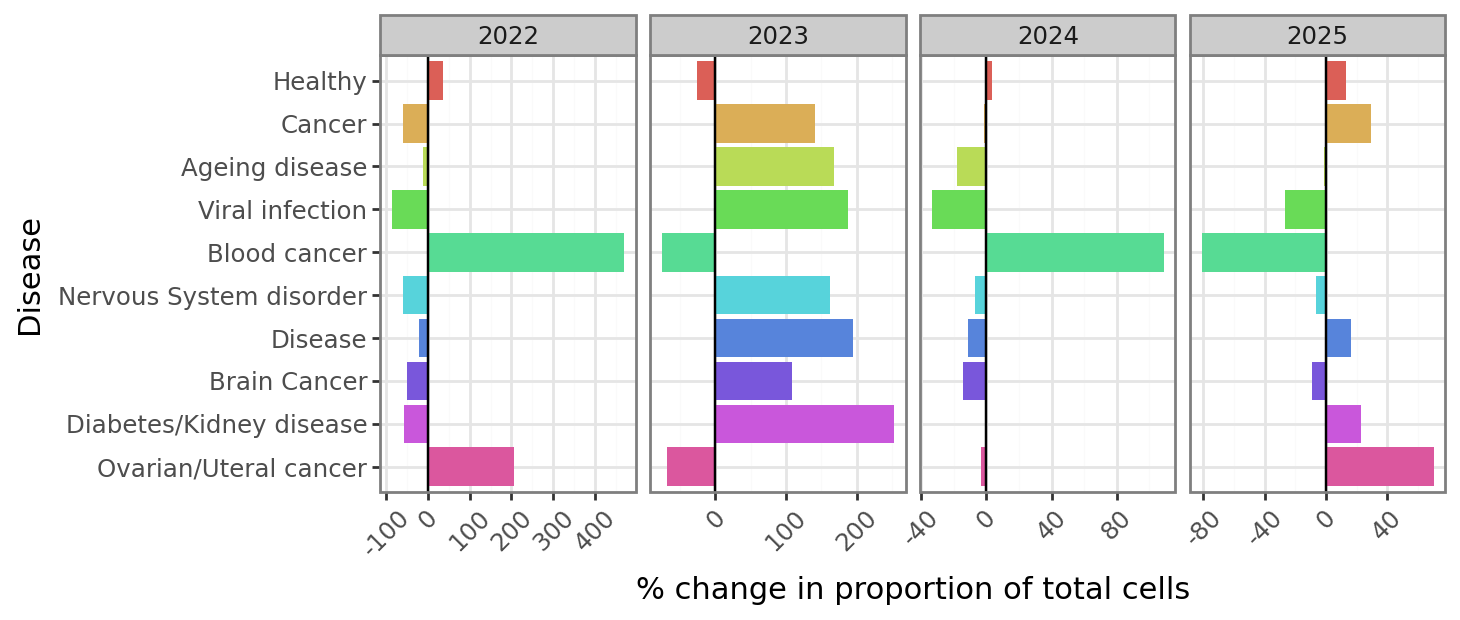

In [ ]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# set color mapping
color_mapping = dict(zip(disease_order, pn.scale_color_discrete().palette(len(disease_order))))

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order[::-1])

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="disease_group", y="pct_change", fill="disease_group")
    ) +
    pn.geom_col() +
    pn.geom_hline(pn.aes(yintercept=0), color="black") +
    pn.scale_fill_manual(values=color_mapping) +
    pn.facet_grid(". ~ release_date_year", scales="free_x") +
    pn.labs(
        x = "Disease",
        y = "% change in proportion of total cells",
        fill = "Direction",
    ) +
    pn.coord_flip() +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.3, 3.1),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
        legend_position="none",
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [59]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_pct-change.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.3 x 3.1 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_pct-change.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_pct-change.svg


# plotting 

## UMIs per cell

In [70]:
df_cells["median_umi_per_cell_norm"] = df_cells["median_umi_per_cell"] / df_cells["median_reads_per_cell"]
df_cells["median_umi_per_cell_norm"].describe()

count    61422.000000
mean         0.466722
             ...     
75%          0.689804
max          3.203809
Name: median_umi_per_cell_norm, Length: 8, dtype: float64

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


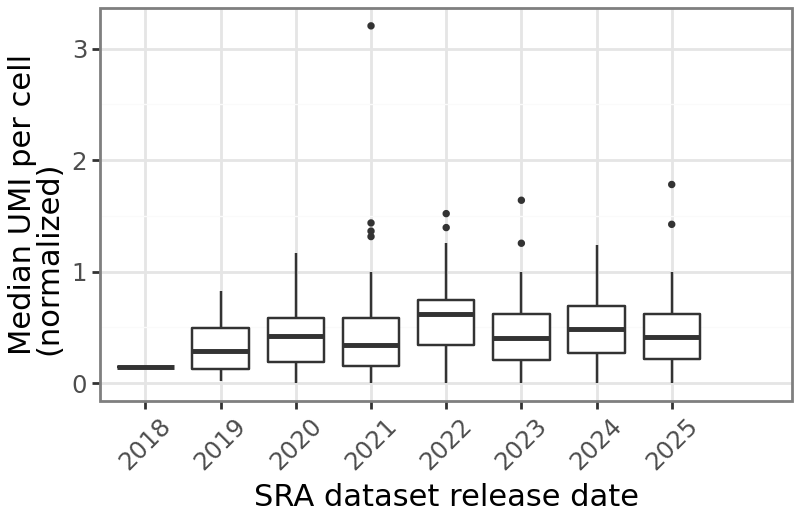

In [71]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_umi_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [72]:
# save as svg
outfile = base_dir / "figures" / "sra_umis-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


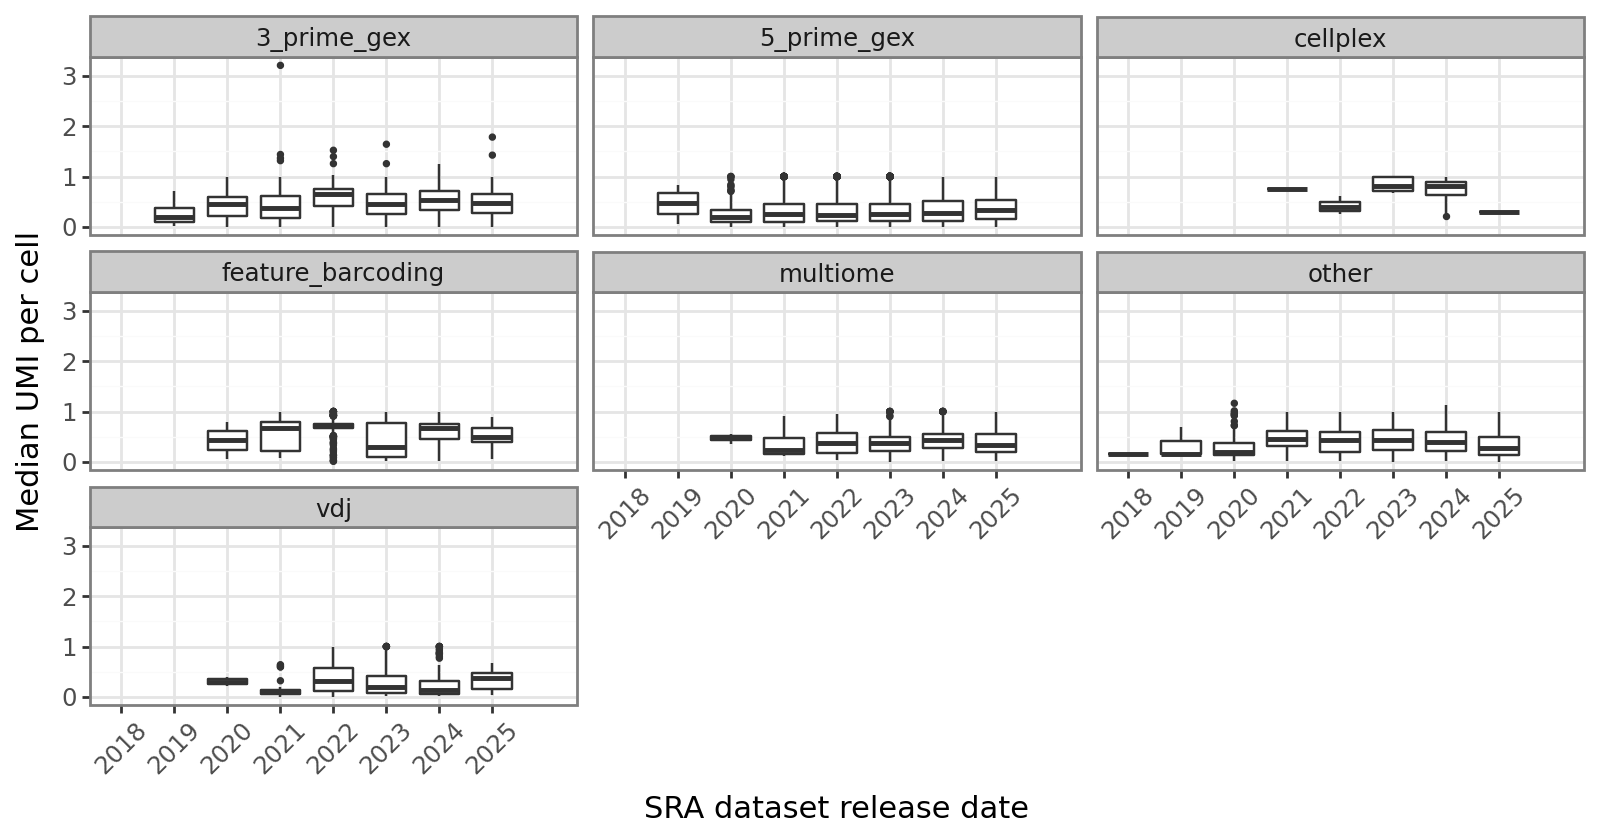

In [73]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_umi_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.facet_wrap("tech_10x") +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

#### UMIs by time and tech_10x

In [74]:
# aggregate by tech_10x and release data; calc mean and stdev
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"median_umi_per_cell_norm": ["mean", "std"]}).reset_index()
df_cells_sum.columns = ["release_date_year", "tech_10x", "mean_umis", "std_umis"]

# fill in missing years
df_cells_sum = pandas_complete(
    df_cells_sum,
    group_cols=["release_date_year", "tech_10x"],
    fill_cols={"mean_umis": 0}
)
# convert NaN to 0
df_cells_sum = df_cells_sum.fillna(0)
df_cells_sum

,release_date_year,tech_10x,mean_umis,std_umis
0,2018,other,0.149192,0.000000
1,2018,3_prime_gex,0.000000,0.000000
...,...,...,...,...
54,2025,vdj,0.332247,0.187923
55,2025,cellplex,0.300459,0.015475


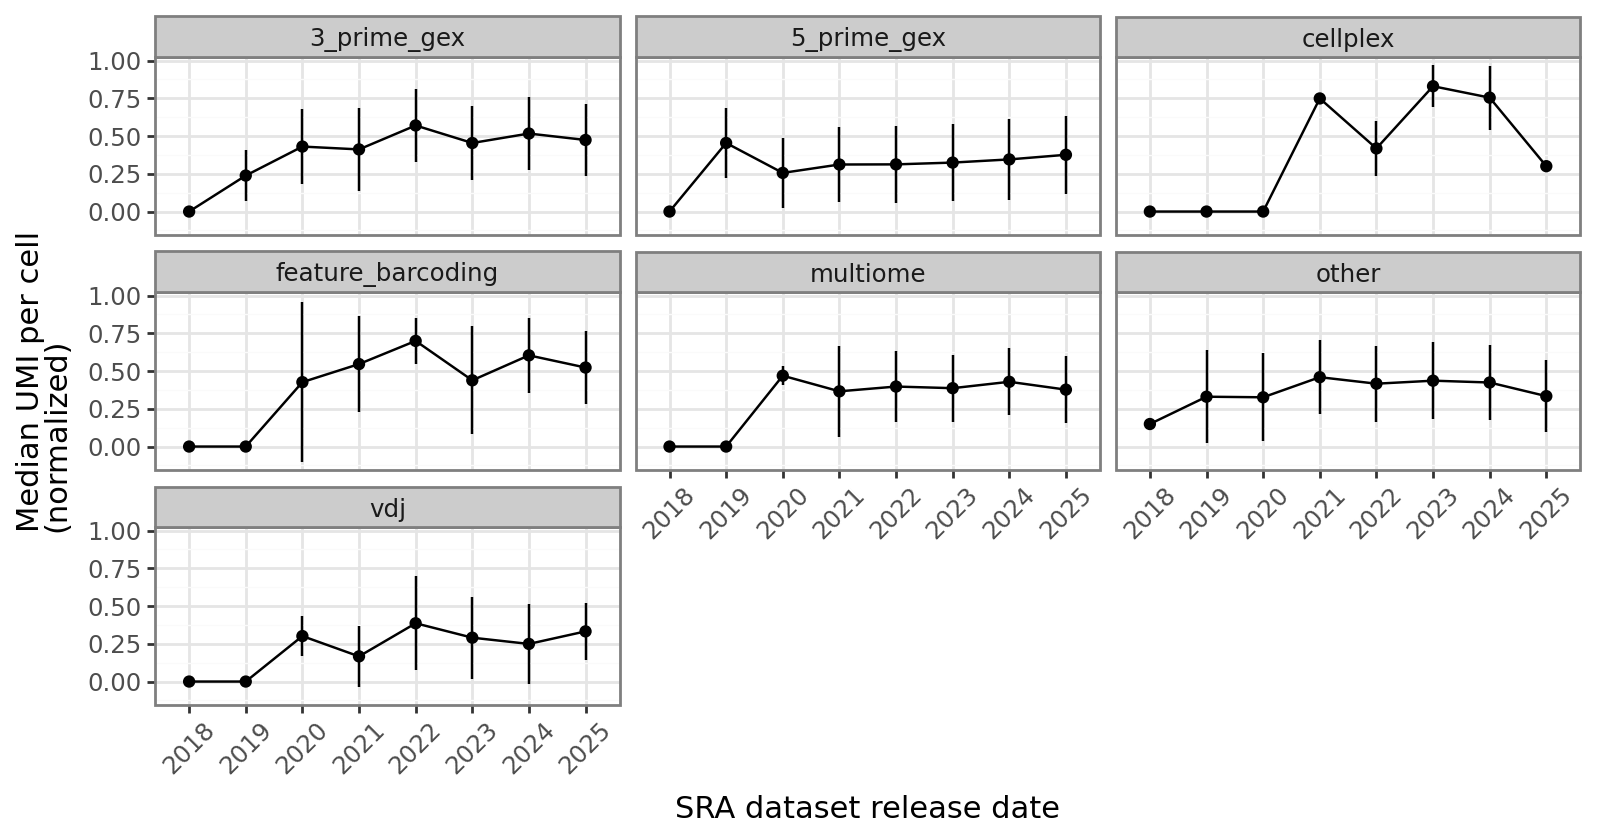

In [75]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="mean_umis")
    ) +
    pn.geom_linerange(pn.aes(ymin="mean_umis - std_umis", ymax="mean_umis + std_umis")) +
    pn.geom_line(pn.aes(group="tech_10x")) +
    pn.geom_point() +
    pn.facet_wrap("tech_10x") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [76]:
# save as svg
outfile = base_dir / "figures" / "sra_umis-by-time_tech10x.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time_tech10x.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time_tech10x.svg


# Median genes per cell

In [85]:
df_cells["median_feature_per_cell_norm"] = df_cells["median_feature_per_cell"] / df_cells["median_reads_per_cell"]
df_cells["median_feature_per_cell_norm"].describe()

count    61422.000000
mean         0.231784
             ...     
75%          0.319630
max          1.000000
Name: median_feature_per_cell_norm, Length: 8, dtype: float64

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


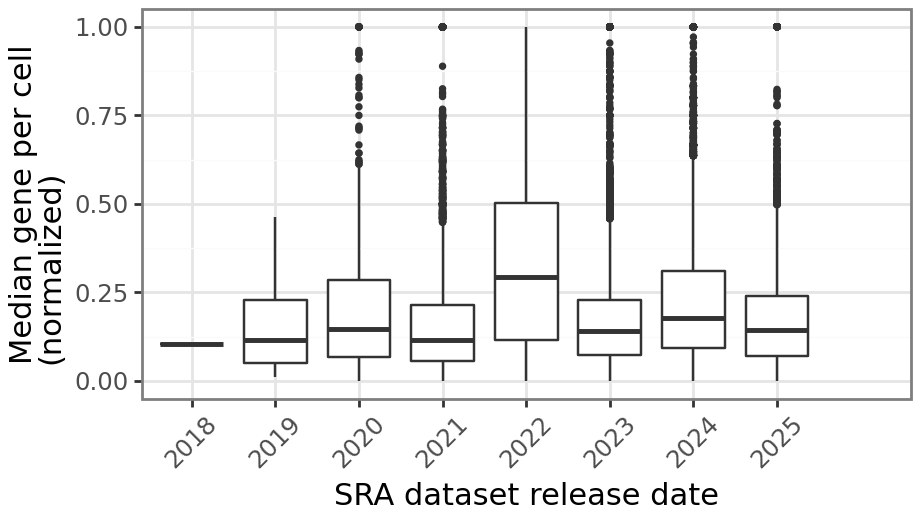

In [86]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_feature_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median gene per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [87]:
# save as svg
outfile = base_dir / "figures" / "sra_genes-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg


## Reads per cell

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


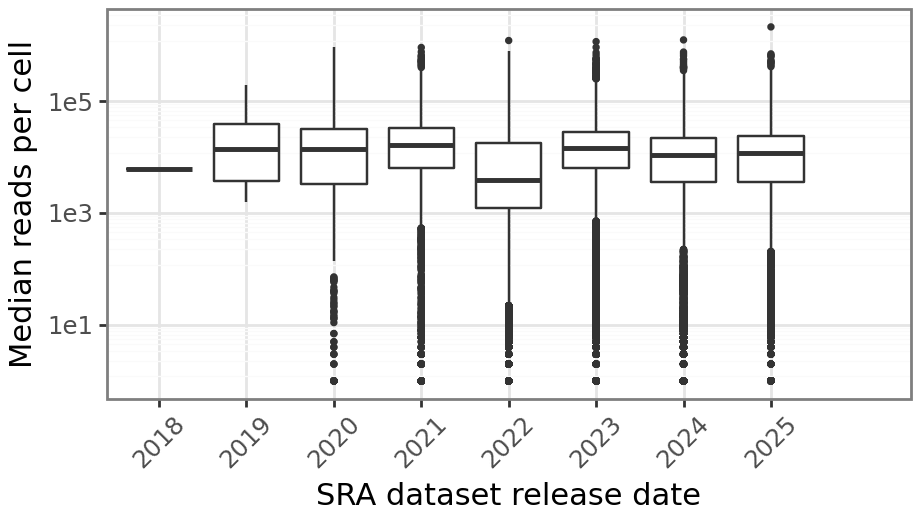

In [80]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_reads_per_cell")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median reads per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [81]:
# save as svg
outfile = base_dir / "figures" / "sra_reads-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time.svg


#### By time and tech_10x

In [82]:
# aggregate by tech_10x and release data; calc mean and stdev
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"median_reads_per_cell": ["mean", "std"]}).reset_index()
df_cells_sum.columns = ["release_date_year", "tech_10x", "mean_reads", "std_reads"]

# fill in missing years
df_cells_sum = pandas_complete(
    df_cells_sum,
    group_cols=["release_date_year", "tech_10x"],
    fill_cols={"mean_reads": 0}
)
# convert NaN to 0
df_cells_sum = df_cells_sum.fillna(0)
df_cells_sum

,release_date_year,tech_10x,mean_reads,std_reads
0,2018,other,6066.000000,0.000000
1,2018,3_prime_gex,0.000000,0.000000
...,...,...,...,...
54,2025,vdj,13886.431034,22763.262661
55,2025,cellplex,32371.000000,1787.565943


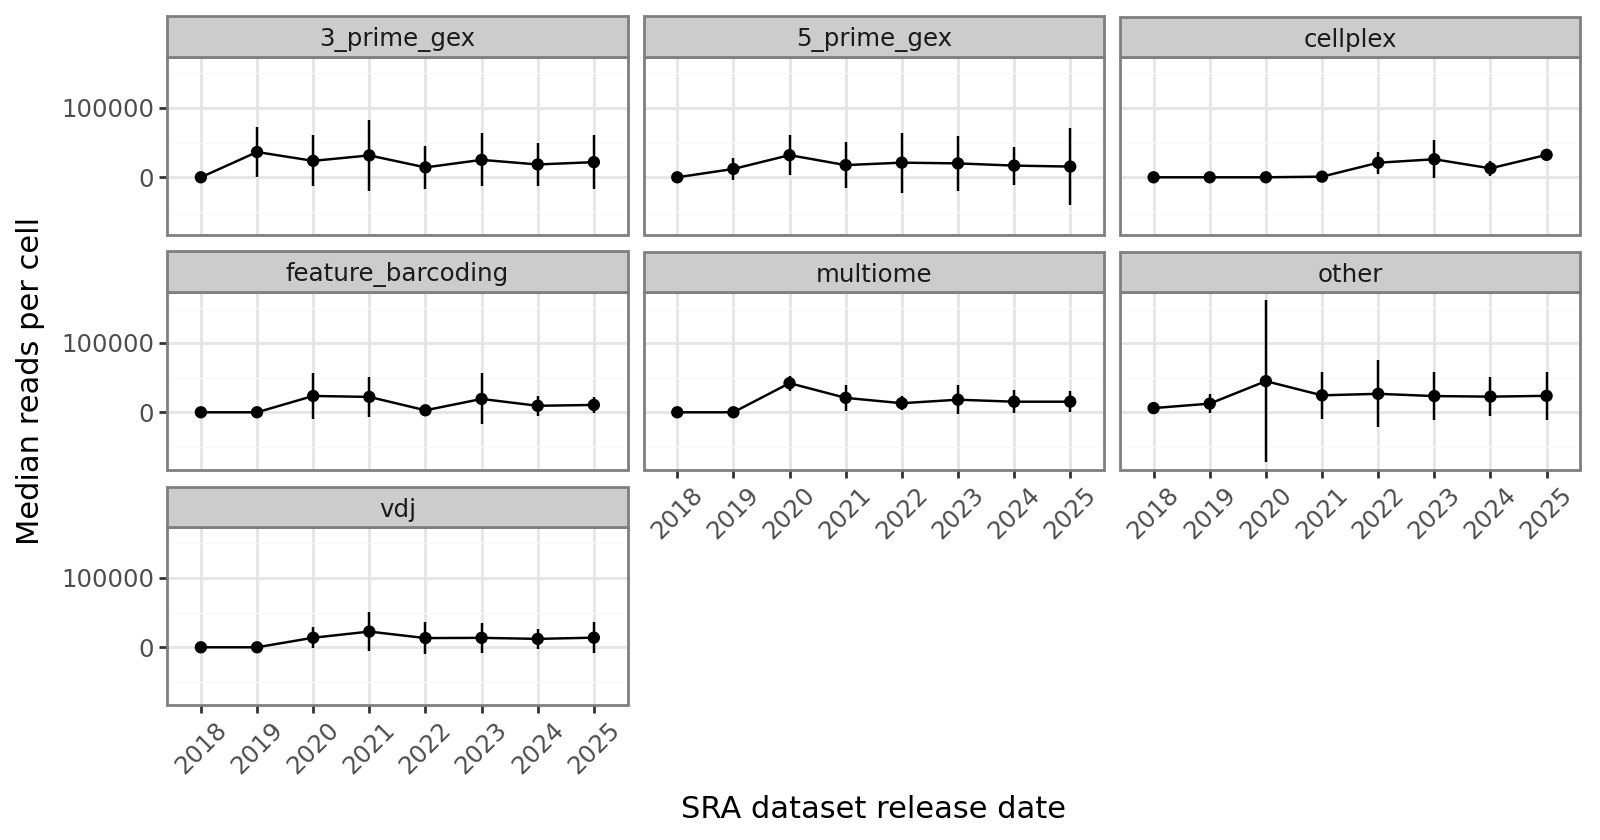

In [83]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="mean_reads")
    ) +
    pn.geom_linerange(pn.aes(ymin="mean_reads - std_reads", ymax="mean_reads + std_reads")) +
    pn.geom_line(pn.aes(group="tech_10x")) +
    pn.geom_point() +
    pn.facet_wrap("tech_10x") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median reads per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [84]:
# save as svg
outfile = base_dir / "figures" / "sra_reads-by-time_tech10x.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time_tech10x.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time_tech10x.svg


# --OLD--

### Cells by month

In [ ]:
# summarize cells by month and tech_10x
df_cells_sum = df_cells.groupby(["release_date_month", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
# filter
df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
# if tech_10x == "not_applicable", set to "other"
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

In [ ]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_month", y="estimated_number_of_cells", fill="organism")
    ) +
    pn.geom_col() +
    pn.scale_y_log10() +
    pn.facet_wrap("~tech_10x", ncol=2) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Estimated Number of Cells",
        fill = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(14, 10),
        axis_text_x=pn.element_text(angle=90, hjust=0.9, size=7),
    )
)
p